## Representation of performance with each parameter

In [32]:
import pandas as pd
import json
import glob
import re
import numpy as np
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt

#### Benchmark data

In [ ]:
with open("./output_bench/benchmark.pkl","rb") as f:
    list_benchmark = pkl.load(f)

### Data

In [3]:
with open("./evaluation/evaluation_final.pkl","rb") as f:
        list_dataframes = pkl.load(f)

In [41]:
toplots = []
for subset in list_dataframes:
    toplot = subset.loc[:,['test_settings','eval_score_gemini-2.0-flash','Relevance','Correctness','Groundedness','Retrieval']]
    values = [toplot.test_settings[0].split('_')[i] for i in [1,3,6,7,9]]
    toplot2 = {"Chunk_size": np.repeat(values[0], toplot.shape[0]),
    "LLM_model":np.repeat(values[1], toplot.shape[0]),
    "Embedding_Model":np.repeat(re.sub(r'recursive','',values[2]),toplot.shape[0]),
    "Recursive":np.repeat(values[3], toplot.shape[0]),
    "NumberofDocuments":np.repeat(values[4], toplot.shape[0])}
    toplots.append(pd.concat([pd.DataFrame(toplot2), toplot.loc[:,['eval_score_gemini-2.0-flash','Relevance','Correctness','Groundedness','Retrieval']]], axis=1))
toplot_final = pd.concat(toplots)

### Line Plots

We ensure that the correctness plot based on 1-5 scale contains numerical data and get values from 0 to 1.

In [42]:
toplot_final["eval_score_gemini-2.0-flash"] = toplot_final["eval_score_gemini-2.0-flash"].apply(lambda x: int(x) if isinstance(x, str) else 0)
toplot_final["eval_score_gemini-2.0-flash"] = toplot_final["eval_score_gemini-2.0-flash"]/5

In [56]:
toplot_final.groupby(["Chunk_size","Embedding_Model", "Recursive", "NumberofDocuments"])["eval_score_gemini-2.0-flash"].mean()

/tmp/ipykernel_3780717/1148214971.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  toplot_final.groupby(["Chunk_size","Embedding_Model", "Recursive", "NumberofDocuments"])["eval_score_gemini-2.0-flash"].mean()


Chunk_size  Embedding_Model           Recursive  NumberofDocuments
1000        GIST-small-Embedding-v0   False      4                    0.844444
                                                 5                    0.876190
                                                 6                    0.882540
                                                 7                    0.898413
                                                 8                    0.939683
                                                                        ...   
2000        snowflake-arctic-embed-s  True       6                    0.765079
                                                 7                    0.790476
                                                 8                    0.780952
                                                 9                    0.800000
                                                 10                   0.809524
Name: eval_score_gemini-2.0-flash, Length: 126, dtype: float64

In [57]:
toplot_final["NumberofDocuments"] = pd.Categorical(values=toplot_final["NumberofDocuments"], categories=["4","5","6","7","8","9","10"], ordered=True)

In [ ]:
toplot_final.groupby(['Embedding_Model','NumberofDocuments','Recursive','Chunk_size'])[['Relevance','Groundedness','Correctness','Retrieval']].mean()

/tmp/ipykernel_3780717/3923218774.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  toplot_final.groupby(['Embedding_Model','NumberofDocuments','Recursive','Chunk_size'])[['Relevance','Groundedness','Correctness','Retrieval']].mean()


Relevance  \
Embedding_Model          NumberofDocuments Recursive Chunk_size              
GIST-small-Embedding-v0  4                 False     1000         0.984127   
                                                     1500         1.000000   
                                                     2000         0.968254   
                                           True      1000         0.984127   
                                                     1500         0.952381   
...                                                                    ...   
snowflake-arctic-embed-s 10                False     1500         0.984127   
                                                     2000         0.952381   
                                           True      1000         0.952381   
                                                     1500         1.000000   
                                                     2000         0.968254   

                                                                 Groundedness  \
Embedding_Model          NumberofDocuments Recursive Chunk_size                 
GIST-small-Embedding-v0  4                 False     1000            0.984127   
                                                     1500            1.000000   
                                                     2000            0.984127   
                                           True      1000            1.000000   
                                                     1500            0.968254   
...                                                                       ...   
snowflake-arctic-embed-s 10                False     1500            0.984127   
                                                     2000            0.984127   
                                           True      1000            1.000000   
                                                     1500            0.984127   
                                                     2000            1.000000   

                                                                 Correctness  \
Embedding_Model          NumberofDocuments Recursive Chunk_size                
GIST-small-Embedding-v0  4                 False     1000           0.857143   
                                                     1500           0.761905   
                                                     2000           0.746032   
                                           True      1000           0.841270   
                                                     1500           0.793651   
...                                                                      ...   
snowflake-arctic-embed-s 10                False     1500           0.761905   
                                                     2000           0.714286   
                                           True      1000           0.857143   
                                                     1500           0.730159   
                                                     2000           0.730159   

                                                                 Retrieval  
Embedding_Model          NumberofDocuments Recursive Chunk_size             
GIST-small-Embedding-v0  4                 False     1000         1.000000  
                                                     1500         0.984127  
                                                     2000         0.984127  
                                           True      1000         1.000000  
                                                     1500         0.968254  
...                                                                    ...  
snowflake-arctic-embed-s 10                False     1500         0.936508  
                                                     2000         0.936508  
                                           True      1000         0.952381  
                                                     1500         0.904762  
                               

## Check the variable with the highest std

[Text(0.5, 1.0, 'Mean of the different metrics')]

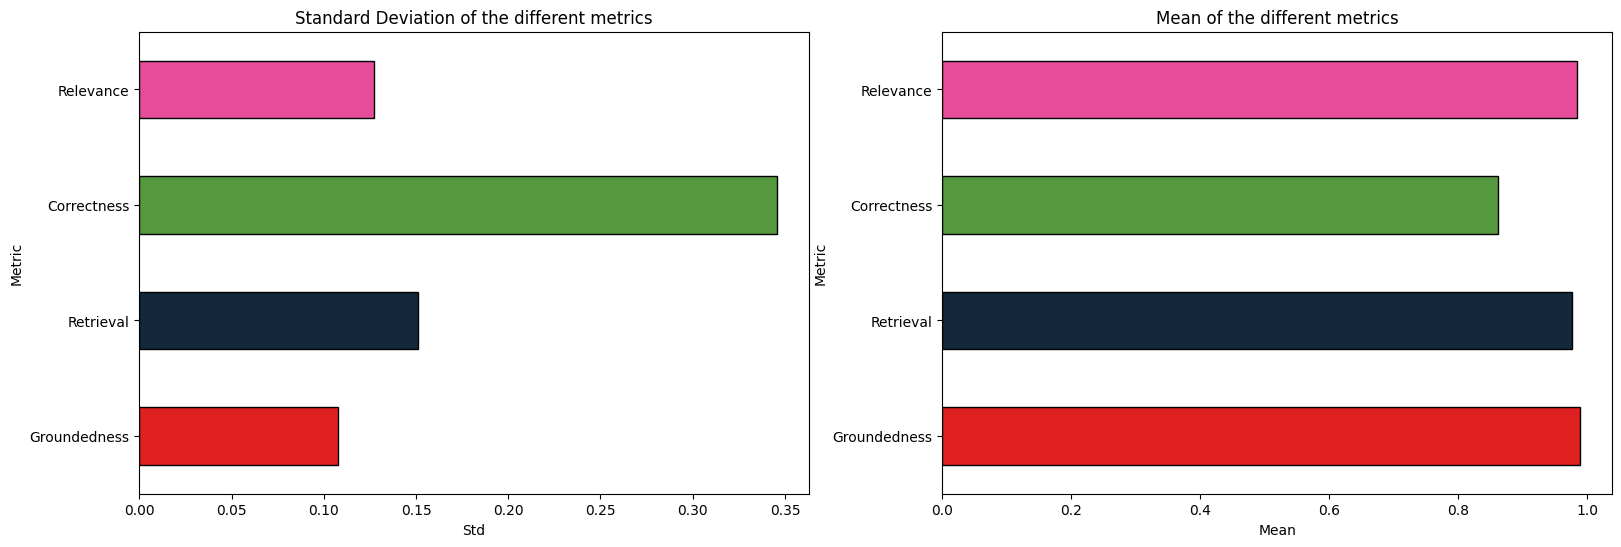

In [66]:
palette = {'Relevance': "#ff3399", 'Correctness': "#4ea72e", 'Retrieval': "#0e2841", 'Groundedness': "#ff0000"}

fig, ax = plt.subplots(1,2, figsize=(19,6))

plot_std = pd.DataFrame({ "Metric" : ["Relevance","Correctness","Retrieval","Groundedness"],
              "Std": [float(toplot_final['Relevance'].std()),float(toplot_final['Correctness'].std()),float(toplot_final['Retrieval'].std()),float(toplot_final['Groundedness'].std())],
              "Mean" : [float(toplot_final['Relevance'].mean()),float(toplot_final['Correctness'].mean()),float(toplot_final['Retrieval'].mean()),float(toplot_final['Groundedness'].mean())]
})


sns.barplot(data=plot_std, y = "Metric", x = "Std", palette=palette, hue="Metric", edgecolor = "Black", ax=ax[0], width=0.5).set(title='Standard Deviation of the different metrics')
sns.barplot(data=plot_std, y = "Metric", x = "Mean", palette=palette, hue="Metric", edgecolor = "Black", ax=ax[1], width=0.5).set(title='Mean of the different metrics')

In [ ]:
plot_box = pd.DataFrame({ "Metric" : ["Relevance","Correctness","Retrieval","Groundedness"],
              "Std": [float(toplot_final['Relevance'].std()),float(toplot_final['Correctness'].std()),float(toplot_final['Retrieval'].std()),float(toplot_final['Groundedness'].std())],
              "Mean" : [float(toplot_final['Relevance'].mean()),float(toplot_final['Correctness'].mean()),float(toplot_final['Retrieval'].mean()),float(toplot_final['Groundedness'].mean())]
})

,Chunk_size,LLM_model,Embedding_Model,Recursive,NumberofDocuments,eval_score_gemini-2.0-flash,Relevance,Correctness,Groundedness,Retrieval
0,1000,gemini-2.0-flash,e5-small-v2,True,8,1.0,True,True,True,True
1,1000,gemini-2.0-flash,e5-small-v2,True,8,1.0,True,True,True,True
2,1000,gemini-2.0-flash,e5-small-v2,True,8,0.8,True,True,True,True
3,1000,gemini-2.0-flash,e5-small-v2,True,8,1.0,True,True,True,True
4,1000,gemini-2.0-flash,e5-small-v2,True,8,1.0,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...
58,2000,gemini-2.0-flash,e5-small-v2,True,7,1.0,True,True,True,True
59,2000,gemini-2.0-flash,e5-small-v2,True,7,1.0,True,True,True,True
60,2000,gemini-2.0-flash,e5-small-v2,True,7,0.6,True,False,True,True
61,2000,gemini-2.0-flash,e5-small-v2,True,7,1.0,True,True,True,True


In [83]:
to_boxplot = toplot_final.groupby(["Chunk_size","Embedding_Model","Recursive","NumberofDocuments"], observed=False)[['Relevance','Groundedness','Correctness','Retrieval']].mean()
to_boxplot = to_boxplot.melt()

<Axes: xlabel='variable', ylabel='value'>

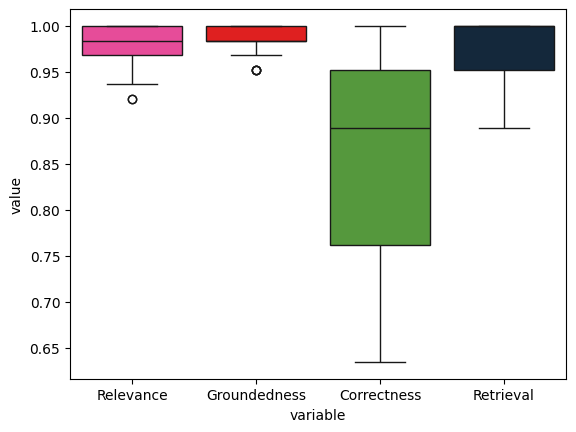

In [85]:
sns.boxplot(data=to_boxplot, y = "value", x = "variable", palette=palette, hue="variable")

## Plot taking account all possible variables

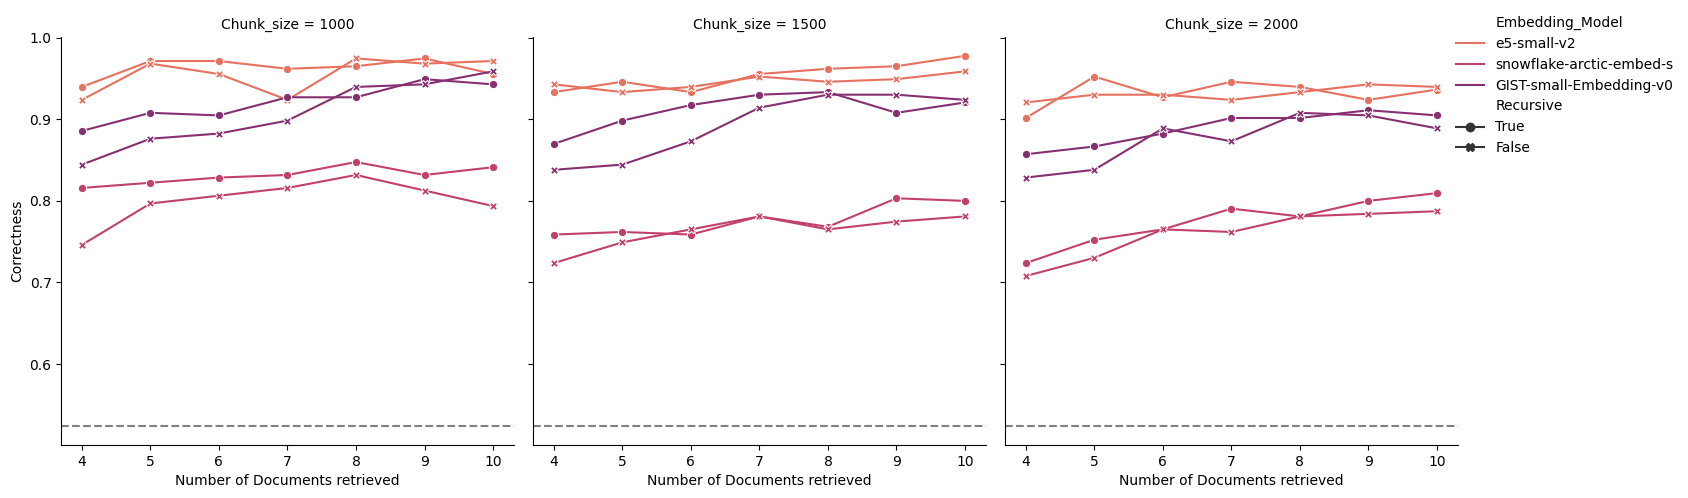

In [48]:
ax = sns.relplot(data=toplot_final, x="NumberofDocuments", y="eval_score_gemini-2.0-flash", hue="Embedding_Model", errorbar=None, style="Recursive", markers=True, dashes=False, palette="flare", col="Chunk_size", kind="line")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set_axis_labels("Number of Documents retrieved", "Correctness")

# Add a horizontal line to each subplot
for ax_i in ax.axes.flat:
	ax_i.axhline(y=list_benchmark[0]['Correctness'].mean(), color='gray', linestyle='--')

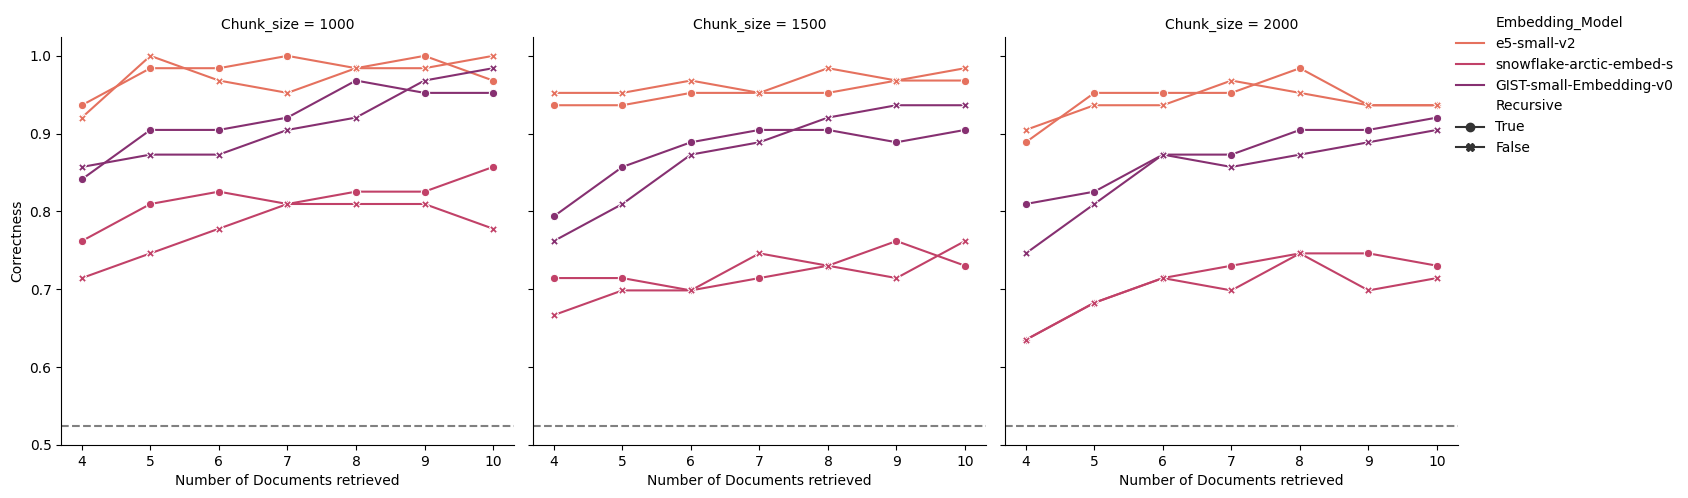

In [49]:
ax = sns.relplot(data=toplot_final, x ="NumberofDocuments", y="Correctness", hue="Embedding_Model", errorbar=None, style= "Recursive", markers=True, dashes=False, palette="flare", col="Chunk_size", kind="line")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set(xlabel='Number of Documents retrieved', ylabel='Correctness')

# Add a horizontal line to each subplot
for ax_i in ax.axes.flat:
	ax_i.axhline(y=list_benchmark[0]['Correctness'].mean(), color='gray', linestyle='--')

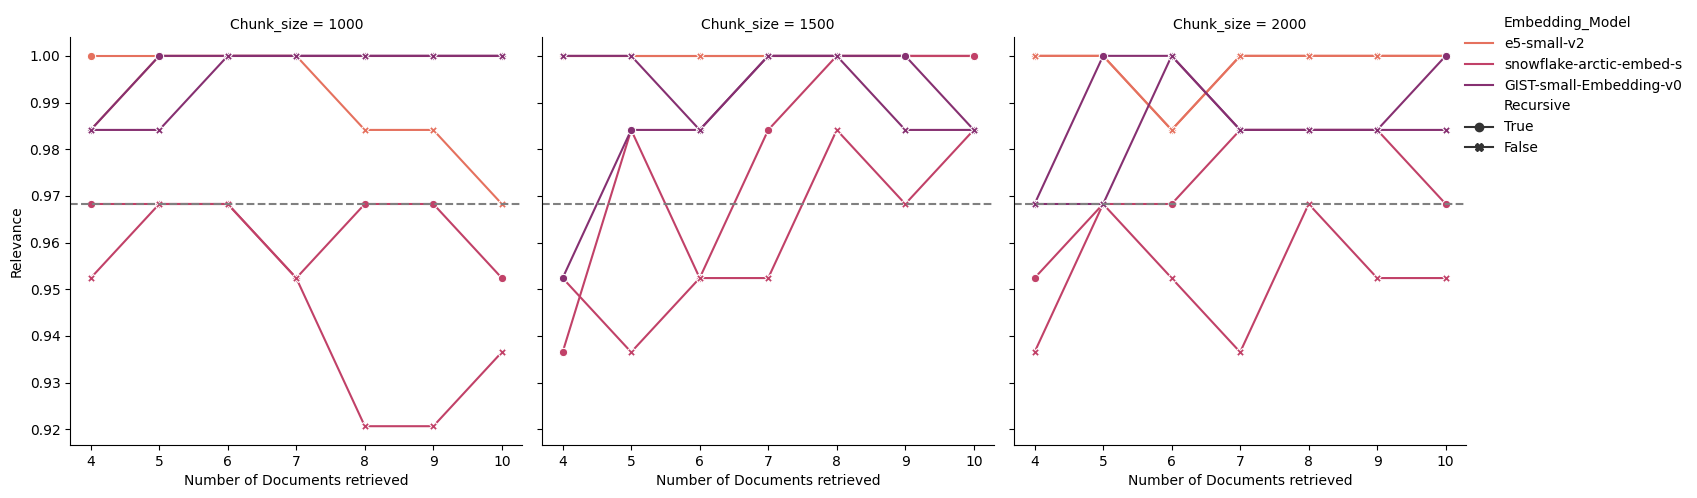

In [50]:
ax = sns.relplot(data=toplot_final, x ="NumberofDocuments", y="Relevance", hue="Embedding_Model", errorbar=None, style= "Recursive", markers=True, dashes=False, palette="flare", col="Chunk_size", kind="line")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set(xlabel='Number of Documents retrieved', ylabel='Relevance')

# Add a horizontal line to each subplot
for ax_i in ax.axes.flat:
	ax_i.axhline(y=list_benchmark[0]['Relevance'].mean(), color='gray', linestyle='--')

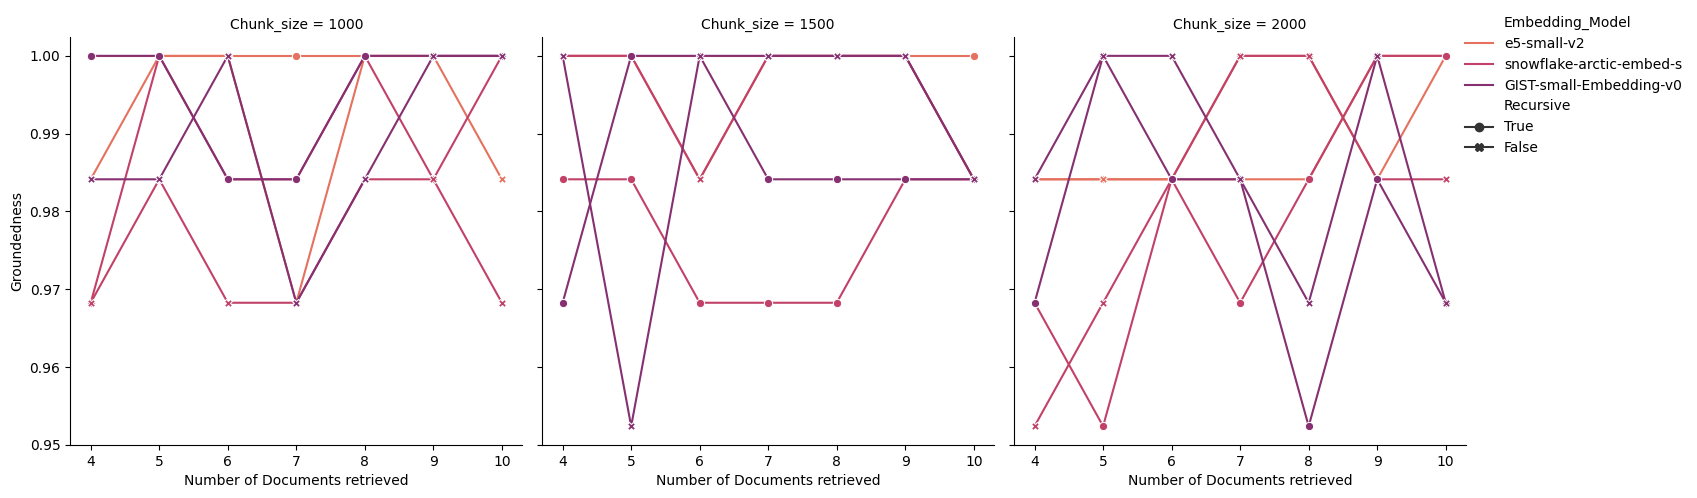

In [15]:
ax = sns.relplot(data=toplot_final, x ="NumberofDocuments", y="Groundedness", hue="Embedding_Model", errorbar=None, style= "Recursive", markers=True, dashes=False, palette="flare", col="Chunk_size", kind="line")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set(xlabel='Number of Documents retrieved', ylabel='Groundedness')

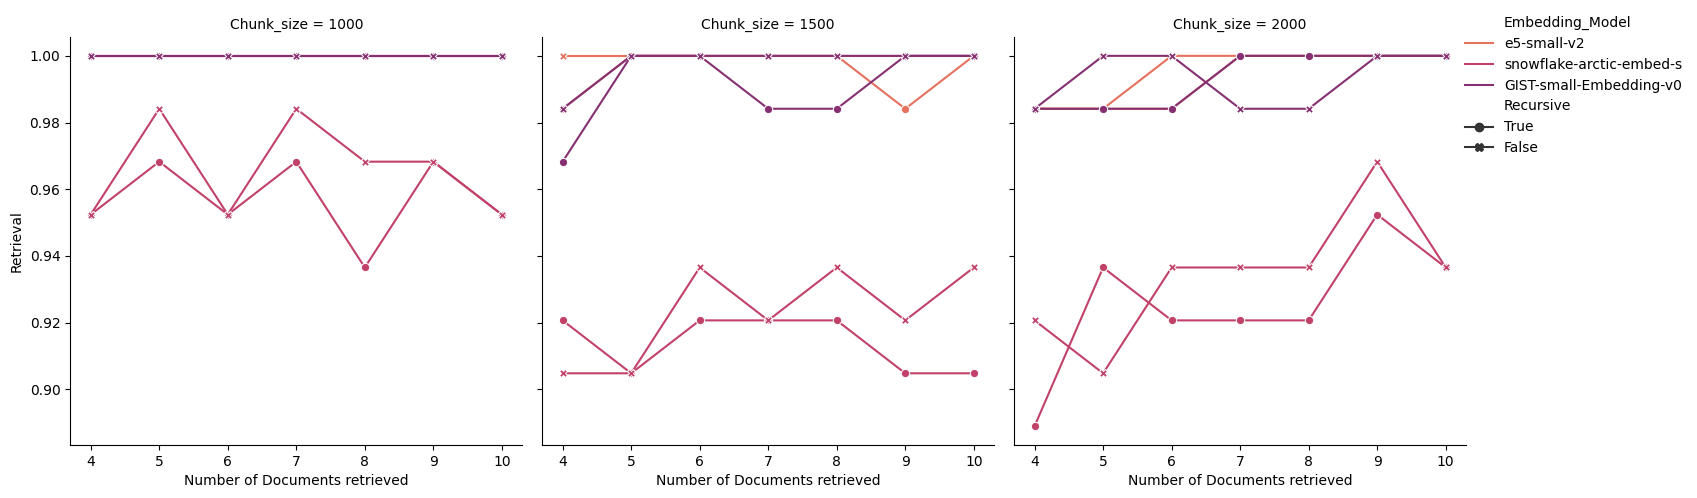

In [16]:
ax = sns.relplot(data=toplot_final, x ="NumberofDocuments", y="Retrieval", hue="Embedding_Model", errorbar=None, style= "Recursive", markers=True, dashes=False, palette="flare", col="Chunk_size", kind="line")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set(xlabel='Number of Documents retrieved', ylabel='Retrieval')